# XAS spectrum

This log is part of the experiment 20139026 at beamline DiProi at Fermi/Trieste (Oct.2017)

Here we varry the FEL energy and get an XAS spectrum for CO/Ru(0001)

### Import

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import hdf5plugin
import h5py
from os import walk

### Define useful functions

In [14]:
def line(x,a,b):
    return a*x+b

def gaussian(x,a,b,c,d):
    return np.abs(a)*np.exp(-4*np.log(2)*(x-b)**2./(c**2))+d

def gaussian0(x,a,b,c):
    return np.abs(a)*np.exp(-4*np.log(2)*(x-b)**2./(c**2))

def fit(function,x,y,p0=None,sigma=None,bounds=None):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma)
    x = np.arange(0,3e3,1e-2)
    curve = function(x,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,x,curve,perr

def discover_files(path):
    # looks in the given directory and returns the filenames,
    for (dirpath, dirnames, filenames) in walk(path):
        break
    return filenames

def load_h5file(file_path):
    h5file = h5py.File(file_path, 'r')
    return h5file

def get_FEL_Spectrum(h5file):
    hor_spectrum   = h5file['photon_diagnostics/Spectrometer/hor_spectrum']
    WavelenghtSpan = h5file['photon_diagnostics/Spectrometer/WavelengthSpan'].value
    Pixel2micron   = h5file['photon_diagnostics/Spectrometer/Pixel2micron'].value
    Wavelenght    = h5file['/photon_diagnostics/Spectrometer/Wavelength'].value
    # alternative approach for wavelenght based on the FEL2 
    #Wavelenght = h5file['photon_source/SeedLaser/WavelengthFEL2'].value
    #Wavelenght/=12*5
    
    ind = np.arange(0,1000)-500
    x = Wavelenght + ind*Pixel2micron*WavelenghtSpan/1000
    h = 4.135667662*10**(-18)#ev s
    c = 299792458 #m/s
    Energy = h*c/x*1e12
    
    return hor_spectrum,Energy

### Files and folders 

In [15]:
file_path = '../01_data/03_XAS_energy_series/'
file_names = discover_files(file_path)
print file_names

['Hor_004_350171250.h5', 'Hor_004_350172883.h5', 'Hor_004_350174413.h5', 'Hor_004_350175964.h5', 'Hor_004_350178107.h5', 'Hor_004_350182377.h5', 'Hor_004_350184359.h5', 'Hor_004_350185951.h5', 'Hor_004_350191896.h5']


### Load data

In [33]:
n_files = len(file_names)
n_shots = 600
n_bins  = 1000 

FEL_energy    = np.zeros([n_files,n_shots,n_bins])
FEL_intensity = np.zeros([n_files,n_shots,n_bins])
XAS_intensity = np.zeros([n_files,n_shots])

for i in range(n_files):
    h5file = h5py.File(file_path+file_names[i], 'r')
    FEL_intensity[i],FEL_energy[i] =  get_FEL_Spectrum(h5file)
    XAS_intensity[i]    = h5file['/Laser/BaslerInt2'].value

### Plot FEL spectrum

(9,) (9,)


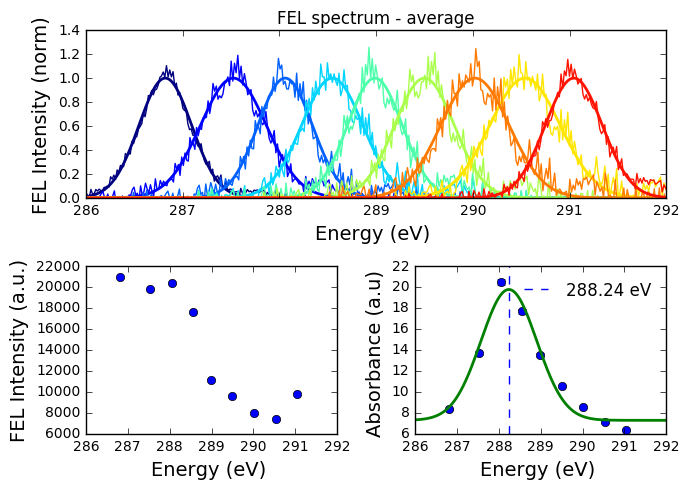

In [170]:
E_mean = np.zeros([n_files]) 
Int = np.zeros([n_files]) 
Abs_norm = np.zeros([n_files]) 

plt.figure(figsize=[7,5])
plt.subplot(2,1,1)
for i in range(n_files):
    color_index = float(i)/(n_files)
    color = plt.cm.jet(color_index)
    FEL_energy_avg = np.average(FEL_energy[i],axis=0)
    FEL_intensity_avg = np.average(FEL_intensity[i],axis=0)
    x,y =FEL_energy_avg,FEL_intensity_avg
    popt,xc,curve,perr = fit(gaussian,x[y>0],y[y>0],p0=[max(y),x[y==max(y)],1,0])
    norm1,mean,offset = popt[0],popt[1],popt[3]
    norm = np.average(y[y>0]-offset)
    Int[i] = np.average(XAS_intensity[i])#/norm
    Abs_norm[i] = np.average(XAS_intensity[i]/norm)
    E_mean[i] = mean
    plt.plot(FEL_energy_avg,(FEL_intensity_avg-offset)/norm1,c=color)
    plt.plot(xc,(curve-offset)/norm1,c=color,lw=2)
plt.xlim(286,292)

plt.ylim([0,1.4])
plt.xlabel(r'Energy (eV) ',size=14)
plt.ylabel(r'FEL Intensity (norm)',size=14)
plt.title('FEL spectrum - average')
plt.legend(frameon=False,loc='upper right', prop={'size': 12})
#plt.grid()

plt.subplot(2,2,3)
plt.plot(E_mean,Int,'o')
plt.xlabel(r'Energy (eV) ',size=14)
plt.ylabel(r'FEL Intensity (a.u.)',size=14)

plt.subplot(2,2,4)
x,y = E_mean,Abs_norm
print x.shape,y.shape
popt,xc,curve,perr = fit(gaussian,x,y,p0=[22,288,1,0])

plt.errorbar(E_mean,Abs_norm,yerr=Abs_sigma,fmt='o')
plt.plot(xc,curve,lw=2)
plt.axvline(x=popt[1],ls='--',label='%.2f eV'%popt[1])
plt.xlim(286,292)
plt.xlabel(r'Energy (eV) ',size=14)
plt.ylabel(r'Absorbance (a.u) ',size=14)
plt.legend(frameon=False,loc='upper right', prop={'size': 12})

plt.tight_layout()

plt.savefig('/Users/fivos/Desktop/fig.png',dpi=300)
plt.show()
